## Music Genre Classification using CNN or classic ML

The idea of this mini project is to deploy a music genre classifier into a web application. Music genre classification (MGC) has been a problem in music information retrieval (MIR) for a long time - starting with the problem of what a genre actually is. For this project, however, I assume that genre boundaries are somewhat known, and use a labeled dataset (GTZAN, Free Music Archive (FMA) or Audio set) to perform classification using either CNN or classic ML techniques, depending on time constraints. 

For the CNN implementation, transfer learning can be done using the VGG-16 architecture with the fixed weights, or just as a starting point. The NN consists of 5 convolutional blocks, and the output layer would be ea softmax activation. I would need to download the architecture, change the output layer, use regularization and dropout to reduce overfitting (reported by the referencee) and feed the songs' spectrograms as inputs. 

For the ML implementation, I would have to manually extract the features. This would be done using the audio library librosa to extract frequency domain features (Mel-frequency Cepstral Coefficients (MFCC), Spectral Centroid, Spectral Roll-off...) and time domain features (Central moments, Zero Crossing Rate (ZCR), Root Means Squared Energy (RMSE)...). Those would then be fed into one or several classifiers for comparison (logistic regression, random forest, gradient boosting, support vector machines...).

The evaluation consists of standard accuracy, f-score and AUC scores.

Other ideas could be speech classification or noise reduction, but both of those seem considerably more complex and less flexible (solely based on DL with RNN, LSTM and CNN with millions of parameters and extensive literature background).

Reference:
Bahuleyan, Hareesh. Music Genre Classification using Machine Learning Techniques. University of Waterloo, 2018.

Ideal: mid-sized problems

- version control
- work with real world dataset
- clean dataset
- maybe extract audio features
- optimize machine learning algorithm
- deploy

work with DL, expandable projects (CNN, like MGC)

- python
- librosa
- tensorflow/keras

Multi-class classification problem



In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import os
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve, roc_curve, roc_auc_score
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance
import seaborn as sns
import tensorflow as tf


## Pushing to github

cd MusicGenreClassifier_MiniProject
git status
git add . (to add all - or no dot and the file names to add instead, to add separate files at a time)
git status # to check that the files are green (ready to be comitted)
git commit -m "title of commit" -m "description for commit"
git push # origin main , if it doesn't work.

In [3]:
# Loading audio files for visualization and analysis

audio_file = "../MLME_MiniProject/classical.00007.wav"
classical, sr = librosa.load(audio_file)
ipd.Audio(audio_file)

In [4]:
# Importing the data set CSV - using the 3 sec dataset for 10x more data compared to the 30 sec

data = pd.read_csv("../MusicGenreClassifier_MiniProject/Data/features_3_sec.csv")
data.head

<bound method NDFrame.head of                filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0     blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1     blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2     blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3     blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4     blues.00000.4.wav   66149          0.335579         0.088129  0.143289   
...                 ...     ...               ...              ...       ...   
9985   rock.00099.5.wav   66149          0.349126         0.080515  0.050019   
9986   rock.00099.6.wav   66149          0.372564         0.082626  0.057897   
9987   rock.00099.7.wav   66149          0.347481         0.089019  0.052403   
9988   rock.00099.8.wav   66149          0.387527         0.084815  0.066430   
9989   rock.00099.9.wav   66149          0.369293         0.086759  0.050524   

       rm

# Data Preprocessing

In [7]:
# Dropping the length and filename columns
data = data.drop(['length', 'filename'], axis=1)  

y = data['label']  # Getting the label column

# Input (X): All columns except for label
X = data.loc[:, data.columns != 'label']

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (9990, 57), y shape: (9990,)


In [8]:
X.head

<bound method NDFrame.head of       chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0             0.335406         0.091048  0.130405  0.003521   
1             0.343065         0.086147  0.112699  0.001450   
2             0.346815         0.092243  0.132003  0.004620   
3             0.363639         0.086856  0.132565  0.002448   
4             0.335579         0.088129  0.143289  0.001701   
...                ...              ...       ...       ...   
9985          0.349126         0.080515  0.050019  0.000097   
9986          0.372564         0.082626  0.057897  0.000088   
9987          0.347481         0.089019  0.052403  0.000701   
9988          0.387527         0.084815  0.066430  0.000320   
9989          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              1972.744388   
1                1816.693777           90525.690866  

In [9]:
# Using LabelEncoder to transform genres into numerical values

le = preprocessing.LabelEncoder()
le.fit(y)
y_le = le.transform(y) # transforms the labels into numerical values
# le.inverse_transform(y) # retrieves the original labels afterwards

print(f"The label encoded output y_le is: {y_le}, original classes: {le.classes_}")

The label encoded output y_le is: [0 0 0 ... 9 9 9], original classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


# Data Normalization

In [10]:
# from https://www.kaggle.com/code/andradaolteanu/work-w-audio-data-visualise-classify-recommend

# Normalize so everything is on the same scale (0 - 1). Normalizing increased the accuracy by almost 20%

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

# Data splitting

In [11]:
# Splitting the data into train, cross-validation and test using sklearn

X_train, X_, y_train, y_ = train_test_split(X, y_le, test_size=0.3, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=1)

print(f"X_train.shape:", X_train.shape, "y_train.shape:", y_train.shape)
print(f"X_cv.shape", X_cv.shape, "y_cv.shape:", y_cv.shape)
print("X_test.shape:", X_test.shape, "y_test.shape", y_test.shape)

X_train.shape: (6993, 57) y_train.shape: (6993,)
X_cv.shape (1498, 57) y_cv.shape: (1498,)
X_test.shape: (1499, 57) y_test.shape (1499,)


# Function to assess different models

In [21]:
def model_assess (model, title = "Default"):
    model.fit(X_train, y_train)
    #predictions = model.predict(X_cv)
    #print('Accuracy', title, ':', round(accuracy_score(y_test, predictions), 5), '\n')
    accuracy = model.score(X_cv, y_cv)
    print(f"Accuracy for {title} is {format(accuracy)}")


# Assessing different models

In [58]:
# Logistic Regression

# similar results with linear and lbfgs solvers
# (acc for lbfgs = 0.53)

logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100000)
model_assess(logistic_regression, "Logistic Regression")


# Support Vector Machine
svm_svc = SVC(decision_function_shape="ovo", probability=True)
model_assess(svm_svc, "Support Vector Machine")


# Neural network - to implement or not? Low score on papers, easy theory


# Random Forest

# Best results achieved not limiting the max_depth and with number of trees in the forest n_estimators=114
# meaning 2 * n_features = 2 * 57 = 114 ; faster than xgb, slightly lower accuracy

random_forest = RandomForestClassifier(n_estimators=114, random_state=0)
model_assess(random_forest, "Random Forest")


# Extreme Gradient Boost (XGBoost)
# Increased chance of working on the misclassified examples

xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# n_estimators=1000, learning_rate=0.05 - Accuracy = 0.9
# n_estimators=1000, learning_rate=0.5 - Accuracy = 0.88
# n_estimators=1000, learning_rate=0.005 - Accuracy = 0.82

Accuracy for Logistic Regression is 0.7002670226969292
Accuracy for Support Vector Machine is 0.7576769025367156
Accuracy for Random Forest is 0.8638184245660881
Accuracy for Cross Gradient Booster is 0.8998664886515354


In [55]:
# Checking for individual accuracy, using Microsoft's function

# Single row test
cv_test = X_cv.iloc[50].values.reshape(-1, 1).T

y_cv_scores = xgb.predict_proba(X_cv) #cv_test for the single row test
classes = xgb.classes_
resultdf = pd.DataFrame(data=y_cv_scores, columns=classes)

topPrediction = resultdf.T.sort_values(by=[0], ascending = [False])
topPrediction



,0,1,2,3,4,5,6,7,8,9,...,1488,1489,1490,1491,1492,1493,1494,1495,1496,1497
5,9.999360e-01,2.298123e-06,0.000002,0.000021,1.852788e-06,0.000308,0.000003,0.000027,0.000018,0.384527,...,2.385311e-07,8.095780e-05,0.000039,0.000159,3.161836e-07,0.000394,0.000026,0.025034,0.016061,0.002146
0,2.223573e-05,2.846035e-04,0.000002,0.004506,1.241366e-04,0.000013,0.000002,0.000698,0.004719,0.000280,...,1.937250e-05,6.799704e-06,0.000063,0.000027,5.790363e-06,0.998533,0.000009,0.974568,0.000858,0.750908
9,1.223290e-05,2.336820e-04,0.000007,0.000707,7.313040e-05,0.007907,0.000042,0.029553,0.002354,0.578128,...,9.381732e-04,3.674394e-06,0.000159,0.000184,1.157245e-04,0.000145,0.003950,0.000194,0.000135,0.000248
3,1.108857e-05,1.084071e-05,0.000002,0.973161,1.235172e-05,0.628544,0.000208,0.966030,0.000635,0.005412,...,9.984750e-01,2.284052e-06,0.000270,0.000129,8.483983e-05,0.000137,0.987684,0.000002,0.000099,0.000141
1,7.034941e-06,3.900399e-06,0.000001,0.000021,1.020226e-05,0.000084,0.000005,0.000219,0.000017,0.000065,...,7.023640e-07,9.998890e-01,0.000040,0.000107,2.375723e-06,0.000003,0.000022,0.000002,0.982708,0.000082
2,6.864123e-06,1.400224e-06,0.003402,0.001084,5.002009e-06,0.013185,0.000002,0.000050,0.000066,0.029272,...,1.049071e-04,1.311834e-05,0.999137,0.899375,7.589073e-06,0.000067,0.000063,0.000185,0.000024,0.245995
6,2.507335e-06,9.994546e-01,0.000002,0.001381,9.992272e-01,0.000019,0.000006,0.003029,0.000134,0.001609,...,1.799973e-05,9.562987e-07,0.000071,0.000013,9.997101e-01,0.000700,0.000031,0.000003,0.000017,0.000071
4,8.500885e-07,5.565654e-06,0.000080,0.018974,4.283816e-04,0.000100,0.000561,0.000338,0.001070,0.000386,...,2.849465e-04,3.167627e-07,0.000119,0.001394,6.757065e-05,0.000014,0.005636,0.000008,0.000033,0.000053
8,6.438074e-07,2.417525e-06,0.996500,0.000058,1.170414e-04,0.000288,0.000360,0.000036,0.990986,0.000198,...,1.580321e-04,2.612557e-06,0.000027,0.094546,5.322599e-06,0.000005,0.002099,0.000002,0.000059,0.000255
7,5.104207e-07,6.894516e-07,0.000002,0.000087,7.104709e-07,0.349553,0.998813,0.000020,0.000002,0.000122,...,6.564032e-07,2.738230e-07,0.000075,0.004066,3.457555e-07,0.000003,0.000480,0.000002,0.000006,0.000101


In [56]:
# Calculating Receiving Operating Characteristic (ROC)'s 
# 'Area Under the Curve' (AUC) score using the previous y_cv_scores

auc = roc_auc_score(y_cv, y_cv_scores, multi_class='ovr') # y_cv_scores[:, 1]
print(auc)

0.9929778126534554


In [57]:
# Classification report, also from scikit learn

y_pred = xgb.predict(X_cv)
print(classification_report(y_cv,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       155
           1       0.91      0.95      0.93       155
           2       0.87      0.88      0.88       174
           3       0.89      0.86      0.87       141
           4       0.93      0.86      0.89       151
           5       0.88      0.88      0.88       148
           6       0.96      0.94      0.95       159
           7       0.91      0.94      0.92       142
           8       0.89      0.88      0.88       143
           9       0.85      0.86      0.86       130

    accuracy                           0.90      1498
   macro avg       0.90      0.90      0.90      1498
weighted avg       0.90      0.90      0.90      1498



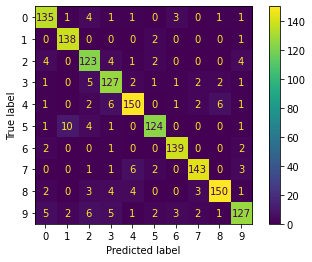

In [60]:
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)
plt.show()